# Visualizer
### Use this script to visualize the neuron traces according to the paper "A Generalized Linear Integrate-and-Fire Neural Model Produces Diverse Spiking Behaviors" by Stefan Mihalas and Ernst Niebur. Further, data was created with a fix length of 1sec (1ms time steps), with noise on the input current, and/or temporal jitter on the time point of the step for dynamic inputs. 

### The script will also calculate the inter-spike intervalls (ISIs) for a single trial and for all repeating trials, whenever possible. For repeating trials, all ISIs are grouped and further statics represent the outcome of all repetitions per class.

In [1]:
import pickle
import torch
import os

import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly

from tactile_encoding.utils.utils import value2key, create_directory


C:\Users\smuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
braille_letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                   'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Space']

max_trials = 100

classes_list = {
    'A': "Tonic spiking",
    'B': "Class 1",
    'C': "Spike frequency adaptation",
    'D': "Phasic spiking",
    'E': "Accommodation",
    'F': "Threshold variability",
    'G': "Rebound spike",
    'H': "Class 2",
    'I': "Integrator",
    'J': "Input bistability",
    'K': "Hyperpolarizing spiking",
    'L': "Hyperpolarizing bursting",
    'M': "Tonic bursting",
    'N': "Phasic bursting",
    'O': "Rebound burst",
    'P': "Mixed mode",
    'Q': "Afterpotentials",
    'R': "Basal bistability",
    'S': "Preferred frequency",
    'T': "Spike latency",
}


In [3]:
def return_isi_fix_len(data, max_trials, norm_count=False, norm_time=False):
    """
    Calculates and returns the ISI for all repetitions of fix length data.
    """
    isi_list = []
    for num, el in enumerate(list(classes_list.values())):
        # print(el)
        # concatenate all ISIs
        isi_fix_len = []
        for trial in range(max_trials):
            # calc spikes per trial
            spikes = np.reshape(np.array(data[trial + num*max_trials][0]), (np.array(
                data[trial + num*max_trials][0]).shape[0]))
            # calc ISI
            isi_fix_len.extend(np.diff(np.where(spikes == 1)[0]))

        if len(isi_fix_len) > 0:
            tmp_fix_len = np.unique(isi_fix_len, return_counts=True)
            isi_fix_len = tmp_fix_len[0]
            if norm_time:
                isi_fix_len = isi_fix_len/max(isi_fix_len)
            isi_fix_len_count = tmp_fix_len[1]
            if norm_count:
                isi_fix_len_count = isi_fix_len_count/max(isi_fix_len_count)
            # create 2d array
            isi = np.vstack([isi_fix_len, isi_fix_len_count])
        isi_list.append(isi)

    return isi_list

In [4]:
data_path_braille = './data/braille_mn_output'  # path to output from Braille data
data_path_original = './data/original_mn_output'  # path to output from MN paper
plot_out = './plots'  # path to save plots
create_directory(plot_out)

'''
neuron parameters:
a: 2.743
A1: 0.03712
A2: -0.5089
b: 11.4
G: 47.02
k1: 200
k2: 20
R1: 0
R2: 1
'''


'\nneuron parameters:\na: 2.743\nA1: 0.03712\nA2: -0.5089\nb: 11.4\nG: 47.02\nk1: 200\nk2: 20\nR1: 0\nR2: 1\n'

# Pre-processing
### extract and concatenate all ISIs for each label and sensor over all data after training and test

In [5]:
file_names = os.listdir(data_path_braille)
file_names = np.sort(file_names)
isi_list = []
isi_dict = {}
for entry in range(27):
    isi_dict[entry] = []
for _, file_name in enumerate(file_names):
    [mn_spk, input_current, trial_label] = torch.load(
        data_path_braille + '/' + file_name, map_location=torch.device('cpu'))
    # convert to numpy
    mn_spk = mn_spk.numpy()
    input_current = input_current.numpy()
    trial_label = trial_label.numpy()

    # extract traces from single batch
    for batch in range(mn_spk.shape[0]):
        isi_list = []

        # loop over all channels
        for channel in range(mn_spk[batch].shape[-1]):
            # calc ISI per channel and append to list
            isi_list.append(np.diff(np.where(mn_spk[batch][:, channel] == 1.0))*1E-2)

        # init dict per label
        if len(isi_dict[trial_label[batch]]) < 1:
            isi_dict[trial_label[batch]] = isi_list
        # extend dict if contains already values
        else:
            # extend the dict for each channel
            for entry in range(len(isi_dict[trial_label[batch]])):
                if len(isi_list[entry]) > 0:
                    isi_dict[trial_label[batch]][entry] = np.append(isi_dict[trial_label[batch]][entry], isi_list[entry], axis=1)


# Compare to paper output

## Per class and channel

KeyboardInterrupt: 

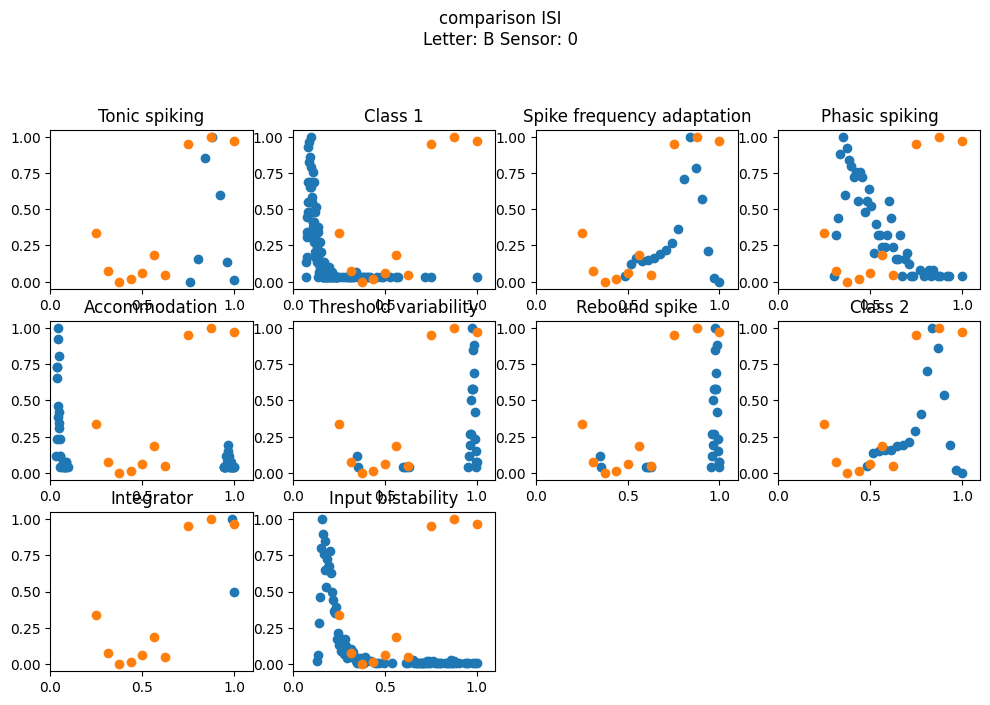

In [6]:
# load ISIs from paper
norm_count = True
norm_time = True
# data_types = ['', '_noisy', '_temp_jitter', '_noisy_temp_jitter_offset']
filename = 'data_encoding_fix_len_noisy_temp_jitter_offset'
infile = open(f"{data_path_original}/{filename}.pkl", 'rb')
data_original = pickle.load(infile)
infile.close()
isi_original = return_isi_fix_len(
    data_original, max_trials, norm_count=norm_count, norm_time=norm_time)

for _, entry in enumerate(isi_dict):
    # iterate over channel
    for channel in range(len(isi_dict[entry])):
        # print('\nWorking on channel: ', channel)
        # extract single ISIs and their count
        isi, count = np.unique(isi_dict[entry][channel][0], return_index=True)

        # only plot if ISIs found in channel
        if len(isi) > 0:
            if norm_time:
                isi = isi/max(isi)
            if norm_count:
                count = count/max(count)

            # create box plots with all classes from paper and single sensor and class for Braille data
            figname = f'comparison ISI\nLetter: {braille_letters[entry]} Sensor: {channel}'
            plt.figure(figsize=(12, 12))
            plt.suptitle(figname)

            # compare to original traces
            for num, isi_original_sel in enumerate(isi_original):             
                # create scatter plot for Braille and original ISIs
                plt.subplot(5, 4, num+1)
                plt.title(f'{classes_list[braille_letters[num]]}')
                plt.scatter(isi_original_sel[0], isi_original_sel[1])
                plt.scatter(isi, count)
                plt.xlim((0, 1.1))

            plt.tight_layout()
            plt.savefig(
                f'{plot_out}/comparison_class_{braille_letters[entry]}_channel_{channel}_scatter.png', dpi=300)
            plt.close()
            # plt.show()


KeyboardInterrupt: 

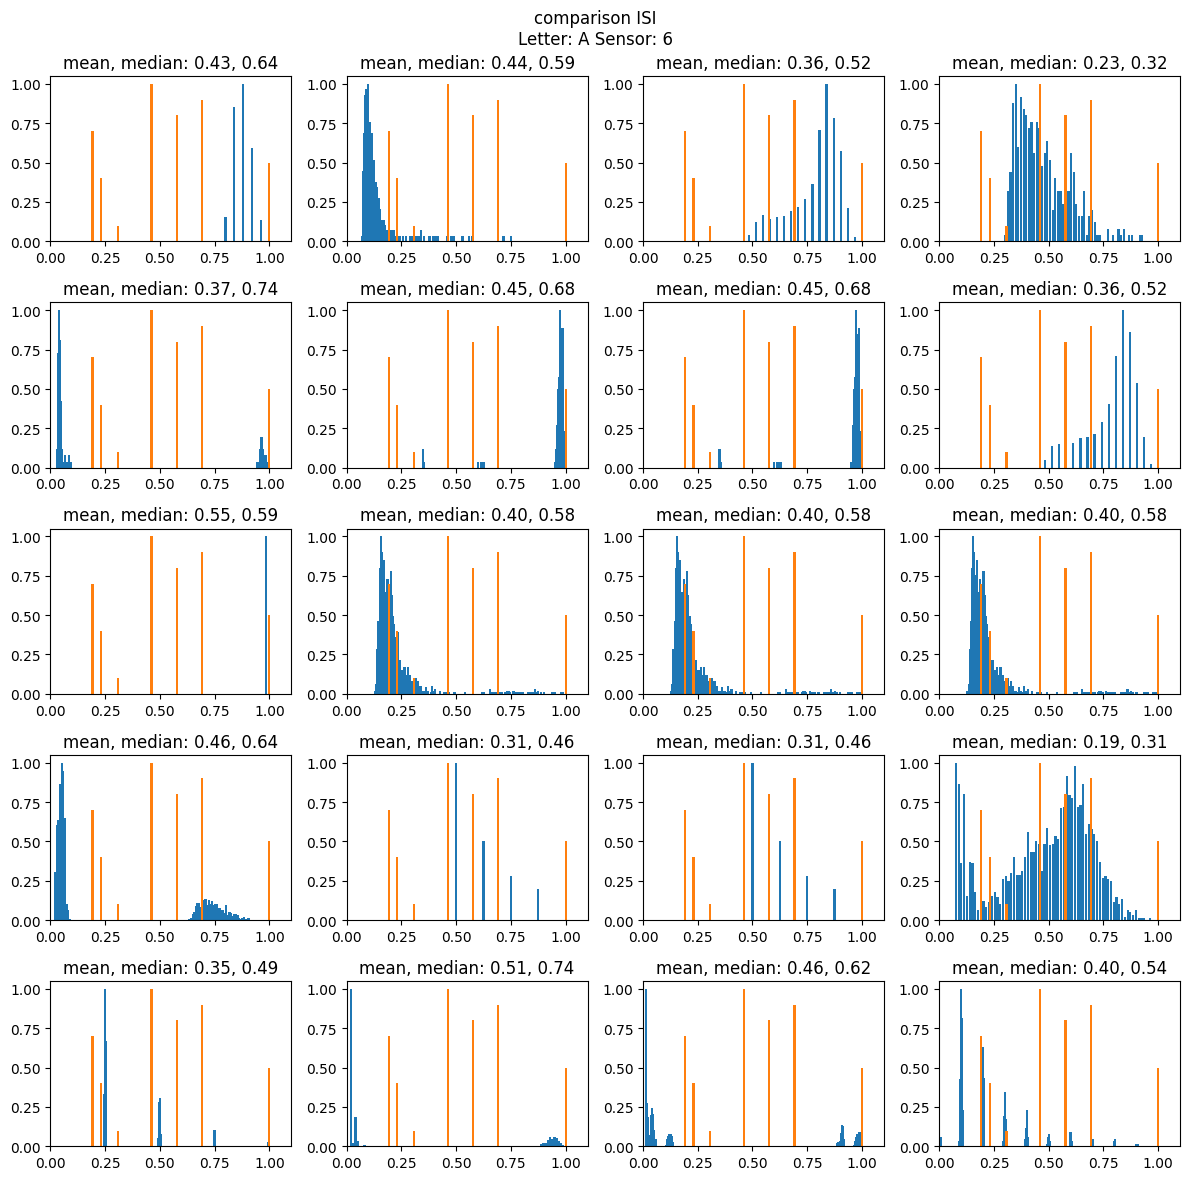

In [9]:
# load ISIs from paper
norm_count = True
norm_time = True
# data_types = ['', '_noisy', '_temp_jitter', '_noisy_temp_jitter_offset']
filename = 'data_encoding_fix_len_noisy_temp_jitter_offset'
infile = open(f"{data_path_original}/{filename}.pkl", 'rb')
data_original = pickle.load(infile)
infile.close()
isi_original = return_isi_fix_len(
    data_original, max_trials, norm_count=norm_count, norm_time=norm_time)

for _, entry in enumerate(isi_dict):
    # iterate over channel
    for channel in range(len(isi_dict[entry])):
        # print('\nWorking on channel: ', channel)
        # extract single ISIs and their count
        isi, count = np.unique(isi_dict[entry][channel][0], return_index=True)

        # only plot if ISIs found in channel
        if len(isi) > 0:
            if norm_time:
                isi = isi/max(isi)
            if norm_count:
                count = count/max(count)

            # create box plots with all classes from paper and single sensor and class for Braille data
            figname = f'comparison ISI\nLetter: {braille_letters[entry]} Sensor: {channel}'
            plt.figure(figsize=(12, 12))
            plt.suptitle(figname)

            # mean and std for channel
            mean_isi_braille = [np.mean(isi), np.std(isi)]
            mean_count_braille = [np.mean(count), np.std(count)]
            # print('Mean Braille: ', [mean_isi_braille[0], mean_count_braille[0]])
            
            # median for channel
            median_isi_braille, median_count_braille = np.median(isi), np.median(count)
            # print('Median Braille: ', [median_isi_braille, median_count_braille])
            
        
            # compare to original traces
            for num, isi_original_sel in enumerate(isi_original):
                # TODO check repetitions of plots!!!
                # # problem: differnet length of input

                # # https://stats.stackexchange.com/questions/194023/how-to-measure-similarity-of-two-lists-of-continuous-data-with-different-length
                # # I: try a curve fit on both distributions and from fitted curve the distance can be calculated

                # II: calc some statistics and use corralation
                import math
                # calc mean and std
                mean_isi_original_sel = [np.mean(isi_original_sel[0]), np.std(isi_original_sel[0])]
                mean_count_original_sel = [np.mean(isi_original_sel[1]), np.std(isi_original_sel[1])]
                
                # print('Mean original: ', [mean_isi_original_sel[0], mean_count_original_sel[0]])
                distance_mean = math.dist([mean_isi_original_sel[0], mean_count_original_sel[0]], [mean_isi_braille[0], mean_count_braille[0]])
                # print('Mean dist.: ', distance_mean)

                # calc meadian
                median_isi_original_sel, median_count_original_sel = np.median(isi_original_sel[0]), np.median(isi_original_sel[1])
                # print('Median original: ', [median_isi_original_sel, median_count_original_sel])
                
                distance_median = math.dist([median_isi_original_sel, median_count_original_sel], [median_isi_braille, median_count_braille])
                # print('Median dist.: ', distance_median)
                # calc Eukledean distance
                # print('Input: ', [isi_original[0], count_original[0]], [isi_braille[0], count_braille[0]])
                
                # print('Distance: ', distance)

                # # calc covariance between mean isi and count
                # covariance = np.cov([isi_original[0], count_original[0]], [isi_braille[0], count_braille[0]])
                # print('covariance: ', covariance)

                # calculate Pearson's correlation
                # https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/
                # from scipy.stats import pearsonr
                # print('Input for Pearson\'s correlation:')
                # print([isi_original[0], count_original[0]], [isi_braille[0], count_braille[0]])
                # # calc Pearson's correlation isi_braille[0]
                # corr, _ = pearsonr([isi_original[0], count_original[0]], [isi_braille[0], count_braille[0]])
                # print('Pearson\'s correlation: ', corr)
                

                # create bar plot for Braille and original ISIs
                plt.subplot(5, 4, num+1)
                # plt.title(f'{isi_original_sel} spikes in {classes_list[braille_letters[num]]}')
                plt.title('mean, median: {:.2f}, {:.2f}' .format(distance_mean, distance_median))
                if norm_time:
                    plt.bar(isi_original_sel[0],
                            isi_original_sel[1], width=0.01)
                    plt.bar(isi, count, width=0.01)
                else:
                    plt.bar(isi_original_sel[0], isi_original_sel[1])
                    plt.bar(isi, count)
                plt.xlim((0, 1.1))

            plt.tight_layout()
            plt.savefig(
                f'{plot_out}/comparison_class_{braille_letters[entry]}_channel_{channel}_bar.png', dpi=300)
            plt.close()
            # plt.show()


## Per channel over all classes

In [ ]:
file_names = os.listdir(data_path_braille)
file_names = np.sort(file_names)
init = True

for _, file_name in enumerate(file_names):
    [mn_spk, input_current, trial_label] = torch.load(
        data_path_braille + '/' + file_name, map_location=torch.device('cpu'))
    # convert to numpy
    mn_spk = mn_spk.numpy()
    input_current = input_current.numpy()
    trial_label = trial_label.numpy()

    # extract traces from single batch
    for batch in range(mn_spk.shape[0]):
        isi_list_channel = []

        # loop over all channels
        for channel in range(mn_spk[batch].shape[-1]):
            # calc ISI per channel and append to list
            isi_list_channel.append(
                np.diff(np.where(mn_spk[batch][:, channel] == 1.0))*1E-2)

        if init:
            # init at first run
            isi_list = isi_list_channel
            init = False
        else:
            # extend with ISIs found in channel per batch
            for num, _ in enumerate(isi_list_channel):
                # print(len(isi_list[num][0]), len(isi_list_channel[num][0]))
                isi_list[num] = np.append(
                    isi_list[num], isi_list_channel[num], axis=1)
                # print(len(isi_list[num][0]))

# check data
# print('Channels: ', len(isi_list))
# for num, isi in enumerate(isi_list):
#     print('ISIs for channel ', num, ': ', len(isi[0]))


In [ ]:
# load ISIs from paper
norm_count = True
norm_time = True
# data_types = ['', '_noisy', '_temp_jitter', '_noisy_temp_jitter_offset']
filename = 'data_encoding_fix_len_noisy_temp_jitter_offset'
infile = open(f"{data_path_original}/{filename}.pkl", 'rb')
data_original = pickle.load(infile)
infile.close()
isi_original = return_isi_fix_len(
    data_original, max_trials, norm_count=norm_count, norm_time=norm_time)

# iterate channel (sensors)
for channel, entry in enumerate(isi_list):
    # extract single ISIs and their count
    isi, count = np.unique(entry[0], return_index=True)
    
    # only plot if ISIs found in channel
    if len(isi) > 0:
        if norm_time:
            isi = isi/max(isi)
        if norm_count:
            count = count/max(count)

        # create box plots with all classes from paper and single sensor and class for Braille data
        figname = f'comparison ISI sensor: {channel}'
        plt.figure(figsize=(12, 12))
        plt.suptitle(figname)

        # compare to original traces
        for num, isi_original_sel in enumerate(isi_original):             
            # create scatter plot for Braille and original ISIs
            plt.subplot(5, 4, num+1)
            plt.title(f'{classes_list[braille_letters[num]]}')
            plt.scatter(isi_original_sel[0], isi_original_sel[1])
            plt.scatter(isi, count)
            plt.xlim((0, 1.1))

        plt.tight_layout()
        plt.savefig(
            f'{plot_out}/comparison_all_classes_channel_{channel}_scatter.png', dpi=300)
        plt.close()
        # plt.show()


In [ ]:
# load ISIs from paper
norm_count = True
norm_time = True
# data_types = ['', '_noisy', '_temp_jitter', '_noisy_temp_jitter_offset']
filename = 'data_encoding_fix_len_noisy_temp_jitter_offset'
infile = open(f"{data_path_original}/{filename}.pkl", 'rb')
data_original = pickle.load(infile)
infile.close()
isi_original = return_isi_fix_len(
    data_original, max_trials, norm_count=norm_count, norm_time=norm_time)

# iterate channel (sensors)
for channel, entry in enumerate(isi_list):
    # extract single ISIs and their count
    isi, count = np.unique(entry[0], return_index=True)
    print(len(isi))
    # only plot if ISIs found in channel
    if len(isi) > 0:
        if norm_time:
            isi = isi/max(isi)
        if norm_count:
            count = count/max(count)

        # create box plots with all classes from paper and single sensor and class for Braille data
        figname = f'comparison ISI sensor: {channel}'
        plt.figure(figsize=(12, 12))
        plt.suptitle(figname)

        # compare to original traces
        for num, isi_original_sel in enumerate(isi_original):
            # create scatter plot for Braille and original ISIs
            plt.subplot(5, 4, num+1)
            plt.title(f'{classes_list[braille_letters[num]]}')
            if norm_time:
                plt.bar(isi_original_sel[0], isi_original_sel[1], width=0.01)
                plt.bar(isi, count, width=0.01)
            else:
                plt.bar(isi_original_sel[0], isi_original_sel[1])
                plt.bar(isi, count)
            plt.xlim((0, 1.1))

        plt.tight_layout()
        plt.savefig(
            f'{plot_out}/comparison_all_classes_channel_{channel}_bar.png', dpi=300)
        plt.close()
        # plt.show()


11
3
108
106
67
0
114
5
4
4
111
0
120
37
105
2
11
21
0
6
117
0
14
17


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.